In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp
import utils
import time
import pickle
import datetime

### Compare methods at different increasing values of N,M at fixed beta

In [4]:
reload(class_flp)
n_testcases = 6
list_N = [100*(i+1) for i in range(n_testcases)]
list_M = [int(2+0.7*i) for i in range(n_testcases)]
size_array = list(zip(list_N, list_M))
# size_array = list(zip(range(50, 251, 50), range(3, 6)))
beta0 = 1
d = 2
N_init_cond = 1
print(f'beta: {beta0}')

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10.0
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3


beta: 1


In [5]:
reload(class_flp)
reload(utils)
# storage arrays
t_cbf = np.zeros((N_init_cond, len(size_array)))
F_cbf = np.zeros((N_init_cond, len(size_array)))

t_slsqp = np.zeros((N_init_cond, len(size_array)))
F_slsqp = np.zeros((N_init_cond, len(size_array)))

t_sgf = np.zeros((N_init_cond, len(size_array)))
F_sgf = np.zeros((N_init_cond, len(size_array)))

for k in range(N_init_cond):
    print(f'Instance {k}\n')
    for i, (N,M) in enumerate(size_array):

        resLoc, Y0, res_means, split_pct, rho = utils.generate_testcase(
            N, M, d, unif_split=True, cluster_cov=10, seed=k, sq_size=20, normalizer=False)
        # allocation cost
        np.random.seed(k)
        alloc_cost = np.random.uniform(100,200,(N,M))
        mean_alloc_cost = np.mean(alloc_cost)
        C = np.random.uniform(0.3,1,len(split_pct))
        # C = np.ones(shape=split_pct.shape)
        C = (C/np.sum(C) + 0.02) * mean_alloc_cost
        B = np.random.uniform(C.min()*0.2, C.min()*0.5, len(split_pct))

        # initialize FLP class
        flp = class_flp.FLP(N, M, d, resLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

        # initialize state
        Y0 = np.random.uniform(10,20,(flp.M, flp.d))
        P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
        P0 = P0/P0.sum(axis=1,keepdims=True)
        x0 = utils.YP2x(Y0, P0)

        print(f'\titer {i}\tsize: ({N,M})\tx0_shape: {x0.shape}')
        
        # CLF_CBF optimization
        t0 = time.time()
        x1, F1 = flp.optimize_CBF_CLF(x0, beta0, p1, p2, gamma, alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=False)
        t1 = time.time()
        t_cbf[k,i] = t1-t0
        F_cbf[k,i] = F1
        print(f'\t\tCBF cost: {F1:.3f}\ttime: {t_cbf[k,i]:.3f}')
        
        # SLSQP optimization
        t2 = time.time()
        x2, F2 = flp.optimize_SLSQP(x0, beta0, ftol=Ftol)
        t3 = time.time()
        t_slsqp[k,i] = t3-t2
        F_slsqp[k,i] = F2
        print(f'\t\tSLSQP cost: {F2:.3f}\ttime: {t_slsqp[k,i]:.3f}')

        # SGF optimization
        t4 = time.time()
        x3, F3 = flp.optimize_SGF(x0, beta0, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=False)
        t5 = time.time()
        t_sgf[k,i] = t5-t4
        F_sgf[k,i] = F3
        print(f'\t\tSGF cost: {F3:.3f}\ttime: {t_sgf[k,i]:.3f}')


Instance 0

	iter 0	size: ((100, 2))	x0_shape: (204,)
		CBF cost: 10.826	time: 0.202
		SLSQP cost: 10.848	time: 0.186
		SGF cost: 11.717	time: 1.634
	iter 1	size: ((200, 2))	x0_shape: (404,)
		CBF cost: 12.041	time: 0.286
		SLSQP cost: 12.080	time: 1.597
		SGF cost: 16.539	time: 2.378
	iter 2	size: ((300, 3))	x0_shape: (906,)
		CBF cost: 12.293	time: 0.743
		SLSQP cost: 12.389	time: 32.249
		SGF cost: 23.347	time: 6.779
	iter 3	size: ((400, 4))	x0_shape: (1608,)
		CBF cost: 10.279	time: 0.870
		SLSQP cost: 10.365	time: 221.371
		SGF cost: 22.954	time: 17.190
	iter 4	size: ((500, 4))	x0_shape: (2008,)
		CBF cost: 10.960	time: 1.928
		SLSQP cost: 12.230	time: 497.704
		SGF cost: 26.545	time: 29.108
	iter 5	size: ((600, 5))	x0_shape: (3010,)
		CBF cost: 11.529	time: 5.688
		SLSQP cost: 11.291	time: 2343.106
		SGF cost: 24.046	time: 64.796



Beta: 1.00000e+00
Avg. Normalized Time — CBF: 1.00, SGF: 11.96, SLSQP: 162.39


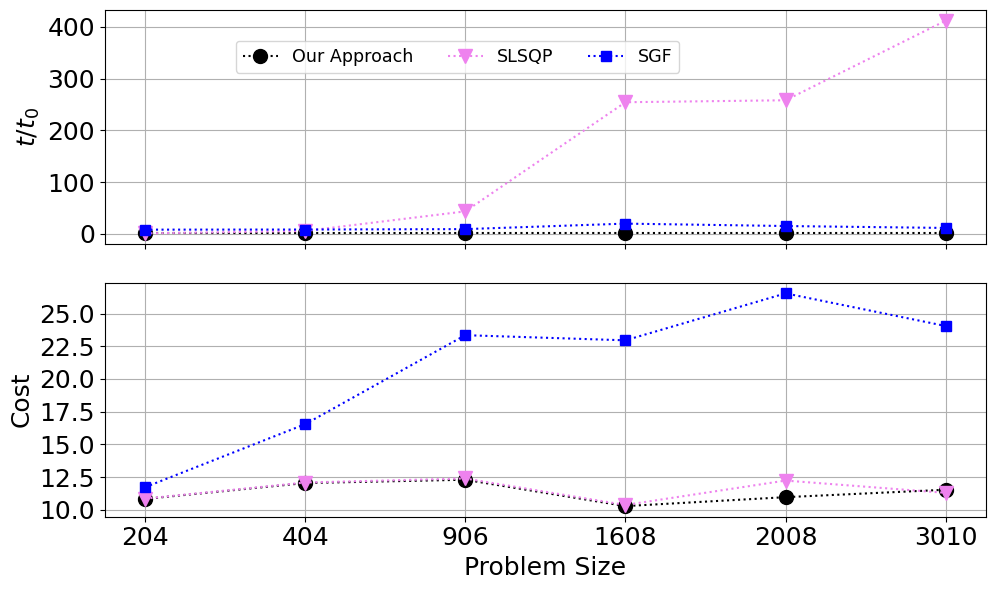

In [9]:
# --- Averages ---
m_t_cbf   = np.mean(t_cbf, axis=0)
m_t_sgf   = np.mean(t_sgf, axis=0)
m_t_slsqp = np.mean(t_slsqp, axis=0)

m_F_cbf   = np.mean(F_cbf, axis=0)
m_F_sgf   = np.mean(F_sgf, axis=0)
m_F_slsqp = np.mean(F_slsqp, axis=0)

# --- Normalize time by CBF ---
norm_m_t_cbf   = m_t_cbf / m_t_cbf
norm_m_t_sgf   = m_t_sgf / m_t_cbf
norm_m_t_slsqp = m_t_slsqp / m_t_cbf

# --- Print comparison ---
print(f"\nBeta: {beta0:.5e}")
print(f"Avg. Normalized Time — CBF: {np.mean(norm_m_t_cbf):.2f}, SGF: {np.mean(norm_m_t_sgf):.2f}, SLSQP: {np.mean(norm_m_t_slsqp):.2f}")

# --- Plotting ---
fontSize = 18
clr = {'our': 'black', 'SGF': 'blue', 'SLSQP': 'violet'}
mk = {'our': 'o', 'SGF': 's', 'SLSQP': 'v'}
mks = {'our': 10, 'SGF': 7, 'SLSQP': 10}
lb = {'our': 'Our Approach', 'SGF': 'SGF', 'SLSQP': 'SLSQP'}

plt.figure(figsize=(10, 6))

# --- Time subplot ---
plt.subplot(2, 1, 1)
plt.plot(norm_m_t_cbf,   color=clr['our'],   marker=mk['our'],   markersize=mks['our'],   label=lb['our'],   linestyle='dotted')
plt.plot(norm_m_t_slsqp, color=clr['SLSQP'], marker=mk['SLSQP'], markersize=mks['SLSQP'], label=lb['SLSQP'], linestyle='dotted')
plt.plot(norm_m_t_sgf,   color=clr['SGF'],   marker=mk['SGF'],   markersize=mks['SGF'],   label=lb['SGF'],   linestyle='dotted')
plt.ylabel(r"$t/t_0$", fontsize=fontSize)
plt.xticks(range(len(size_array)), [" "] * len(size_array))
plt.yticks(fontsize=fontSize)
plt.legend(fontsize=fontSize * 0.7, ncol=3, loc="center", bbox_to_anchor=(0.4, 0.8))
plt.grid(True)

# --- Cost subplot ---
plt.subplot(2, 1, 2)
plt.plot(m_F_cbf,   color=clr['our'],   marker=mk['our'],   markersize=mks['our'],   label=lb['our'],   linestyle='dotted')
plt.plot(m_F_slsqp, color=clr['SLSQP'], marker=mk['SLSQP'], markersize=mks['SLSQP'], label=lb['SLSQP'], linestyle='dotted')
plt.plot(m_F_sgf,   color=clr['SGF'],   marker=mk['SGF'],   markersize=mks['SGF'],   label=lb['SGF'],   linestyle='dotted')
plt.xlabel("Problem Size", fontsize=fontSize)
plt.ylabel("Cost", fontsize=fontSize)
plt.xticks(range(len(size_array)), [f"{n*m + 2*m}" for n, m in size_array], fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.grid(True)

plt.tight_layout()
plt.show()